# ML model for July
Splitting based on spatial distribution

## Import libraries

In [4]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import plotly
from scipy.stats import gaussian_kde
import geopandas as gpd
from shapely.geometry import Point

## Load the data

In [5]:
# import the previously saved stations data to the notebook

final_df_jul_new = None
with open("final_df_jul_new", 'rb') as file:
    # Deserialize and retrieve the variable from the file
    final_df_jul_new = pickle.load(file)

# Load the shapefile for Bavaria
shapefile_path = r"J:\study_project\geoBoundaries-DEU-ADM1-all\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

In [6]:
final_df_jul_new

NO3-N [mg/l]  NO3-N [mg/l] BC                       station_name  \
0        4.821333         2.188384   Strbr. in Höhe v. Stein, obh. KA   
1        2.471000         1.028438  Str.br.von Neundorf nach Bächlein   
2        3.766667         1.714114   Strbr. Höhe Äußerer Bürgergraben   
3        2.734500         1.145806                   Strbr. Oberteich   
4        4.819500         2.106403     Straßenbr zum KW Oberelchingen   
..            ...              ...                                ...   
488      4.124500         1.871883                 800m uh. Wenigrötz   
489      0.316000        -0.923285   800m oh nordwestl Ammeraltwasser   
490      3.992667         1.845623    200m u.h. Bahnl. Markt Schwaben   
491      3.898500         1.743130             700m oh Mündung in Ach   
492      0.568703        -0.512144                 Augsburg Hochablaß   

    station_number                          water_body        lat        lon  \
0            13516                           Ölschnitz  50.062500  11.704167   
1            15123                              Föritz  50.254167  11.212500   
2            20496                          Schwabbach  49.987500   9.979167   
3            23397                        Seibertsbach  49.937500  12.212500   
4            42442                               Leibi  48.437500  10.104167   
..             ...                                 ...        ...        ...   
488         105645                          Rötzerbach  49.329167  12.387500   
489         113898                       Waizackerbach  47.862500  11.129167   
490         130316                 Forstinninger Sempt  48.212500  11.887500   
491         136340  Dinkelshausener Arrondierungskanal  48.645833  11.170833   
492           3044                                Lech  48.345833  10.937500   

     slope_avg  elev_avg  lc_avg_01  ...  soil_avg_04  soil_avg_05  \
0        216.0     584.0       15.0  ...         36.0         16.0   
1        240.0     381.0       22.0  ...         36.0         12.0   
2        118.0     303.0        0.0  ...         43.0         23.0   
3        190.0     589.0       23.0  ...         38.0         15.0   
4        224.0     745.0        6.0  ...         39.0         19.0   
..         ...       ...        ...  ...          ...          ...   
488      148.0     476.0        1.0  ...         38.0         16.0   
489      433.0     875.0       20.0  ...         37.0         17.0   
490       49.0     544.0       19.0  ...         38.0         16.0   
491       96.0     417.0        3.0  ...         37.0         17.0   
492      752.0    1208.0       20.0  ...         39.0         19.0   

     soil_avg_06  soil_avg_07  soil_avg_08  soil_avg_09  soil_avg_10  \
0           15.0         18.0       1236.0        240.0          3.0   
1           14.0         19.0       1287.0        240.0          4.0   
2            8.0         24.0       1282.0        236.0          8.0   
3           17.0         23.0       1215.0        240.0          6.0   
4           12.0         24.0       1269.0        234.0          7.0   
..           ...          ...          ...          ...          ...   
488         16.0         14.0       1293.0        240.0          5.0   
489         12.0         27.0       1260.0        230.0          8.0   
490         10.0         22.0       1305.0        240.0          2.0   
491          9.0         20.0       1247.0        240.0          3.0   
492         14.0         29.0       1199.0        218.0         14.0   

     tmin_avg_7  tmax_avg_7  prec_sum_7  
0         113.0       216.0     11979.0  
1         119.0       227.0      2582.0  
2         125.0       240.0      7430.0  
3         110.0       215.0      4675.0  
4         114.0       222.0   1610541.0  
..          ...         ...         ...  
488       119.0       227.0      4814.0  
489       118.0       218.0    152068.0  
490       119.0       229.0     36842.0  
491       126.0       234.0     20646.0  

## Defining functions

In [7]:
def split_with_spatial_dist(dataframe, bandwidth, train_ratio, block_size, random_seed = None ):
    """
        Splits the given dataset into training and testing sets, maintaining similar spatial distribution in both sets. 
        Uses a gaussian kernel desnsity estimation technique to calculate probabilty density of monitoring stations' location. 
        Using the probabilty density, assigns weights to stations and uses these weights to split the stations into training and testing sets. 
        Note: depending on the user, the dataframe might be different. Hence certain sections of this function might need to be edited depending on 
        the structure of your dataframe. 
        Author: Karan Mahajan, Technical University of Munich, karanmahajan.chd@gmail.com
    Args:
        dataframe (pandas dataframe): The data file with the station latitude and longitude columns
        bandwith (int): Bandwith in kilometer for the kernel density estimation technique
        train_ratio (float): proportion of data to be included in the training set. Recommended is 0.8 
        block_size (int): the size of individual blocks of density values out of which user wants to sample data for testing and training sets.
        random_seed (int): to ensure that results can be reproduces. If not specified, we'll get a different split everytime the function is run. 

    Returns:
        kde: kernel density estimate, that is fitted using the coordinate data
        sorted_df: dataframe sorted according to the density weights (ascending order). The X data in this dataframe is scaled using standard scaler.
        train_ind: indices from sorted_df that go into training set
        test_ind: indices from sorted_df that go into testing set
        scaler: the  scaler used to scale the data
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    train_ind = []
    test_ind = []
    
    # Set the bandwidth in degrees (approximation: 1 degree latitude ≈ 111 km)
    bandwidth_deg = round(bandwidth / 111, 2)  # Convert 50 km to degrees
    
    # Generate the Gaussian Kernel Density Estimate
    xy = np.vstack([dataframe['lon'], dataframe['lat']])
    kde = gaussian_kde(xy, bw_method=bandwidth_deg)

    # Evaluate KDE only over the station points
    density_weights = kde(np.vstack([dataframe['lon'], dataframe['lat']]))

    test_df = final_df_jul_new.copy()

    # Add desnity_weights to the dataframe at a specific column index (better for visualisation)
    test_df['density_val'] = density_weights
    col_order = test_df.columns.tolist()
    col_order.insert(7, col_order[-1])
    col_order.pop(-1)
    test_df = test_df[col_order]

    # Scale the independent variables or features and add them back to the dataframe
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(test_df.iloc[:, 8:])
    scaled_df = pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns[8:])
    scaled_df = scaled_df.astype('float32')  # Explicitly cast to float32 if needed because the data type might not match

    # Replace the original data with the scaled data
    test_df.iloc[:, 8:] = scaled_df


    sorted_df = test_df.sort_values(by='density_val').reset_index(drop=True)

    # Loop through sorted_df in blocks of block_size, and then randomly sample train_ratio*10 samples for training and remaining for testing
    for i in range(0, len(sorted_df),block_size):
        block_indices = list(range(i,min(len(sorted_df), i+block_size)))
        np.random.shuffle(block_indices)
        num_train_block = int(train_ratio*10)
        train_indices_block = block_indices[:num_train_block]
        test_indices_block = block_indices[num_train_block:]

        train_ind.extend(train_indices_block)
        test_ind.extend(test_indices_block)

        np.random.shuffle(train_ind)
        np.random.shuffle(test_ind)


    return kde, sorted_df, train_ind, test_ind, scaler

def data_from_spatial_split(sorted_df, train_ind, test_ind):
    y_train = sorted_df.iloc[train_ind, 1]  # Assuming the target variable is at index 1
    X_train = sorted_df.iloc[train_ind, 8:]  # Assuming features start from index 8

    y_test = sorted_df.iloc[test_ind, 1]
    X_test = sorted_df.iloc[test_ind, 8:]

    return X_train, X_test, y_train, y_test


def pearson_corr_coeff(X,y):
    X_bar = np.mean(X)
    y_bar = np.mean(y)
    numr = np.sum((X-X_bar)*(y-y_bar))
    denmr = np.sqrt(np.sum(np.square(X-X_bar)*np.sum(np.square(y-y_bar))))
    r = numr/denmr
    return r

In [8]:
# Implement the function to get the training and testing data

kde, sorted_df, train_ind, test_ind, scaler = split_with_spatial_dist(final_df_jul_new, 20, 0.8, 10, 42 )
X_train, X_test, y_train, y_test = data_from_spatial_split(sorted_df, train_ind, test_ind)

## Plots to check the splitting process
1. 3D probabilty density plot
2. 2D probability density plot
3. Locations of staions in training and testing sets

In [9]:
    
# Define the extents of the grid
xmin, xmax = final_df_jul_new['lon'].min() - 0.2, final_df_jul_new['lon'].max() + 0.2
ymin, ymax = final_df_jul_new['lat'].min() - 0.2, final_df_jul_new['lat'].max() + 0.2

# Generate a grid of points over the area of interest (Bavaria)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate KDE over the grid (can be used to generate a figure later)
density_values = kde(positions).reshape(xx.shape)

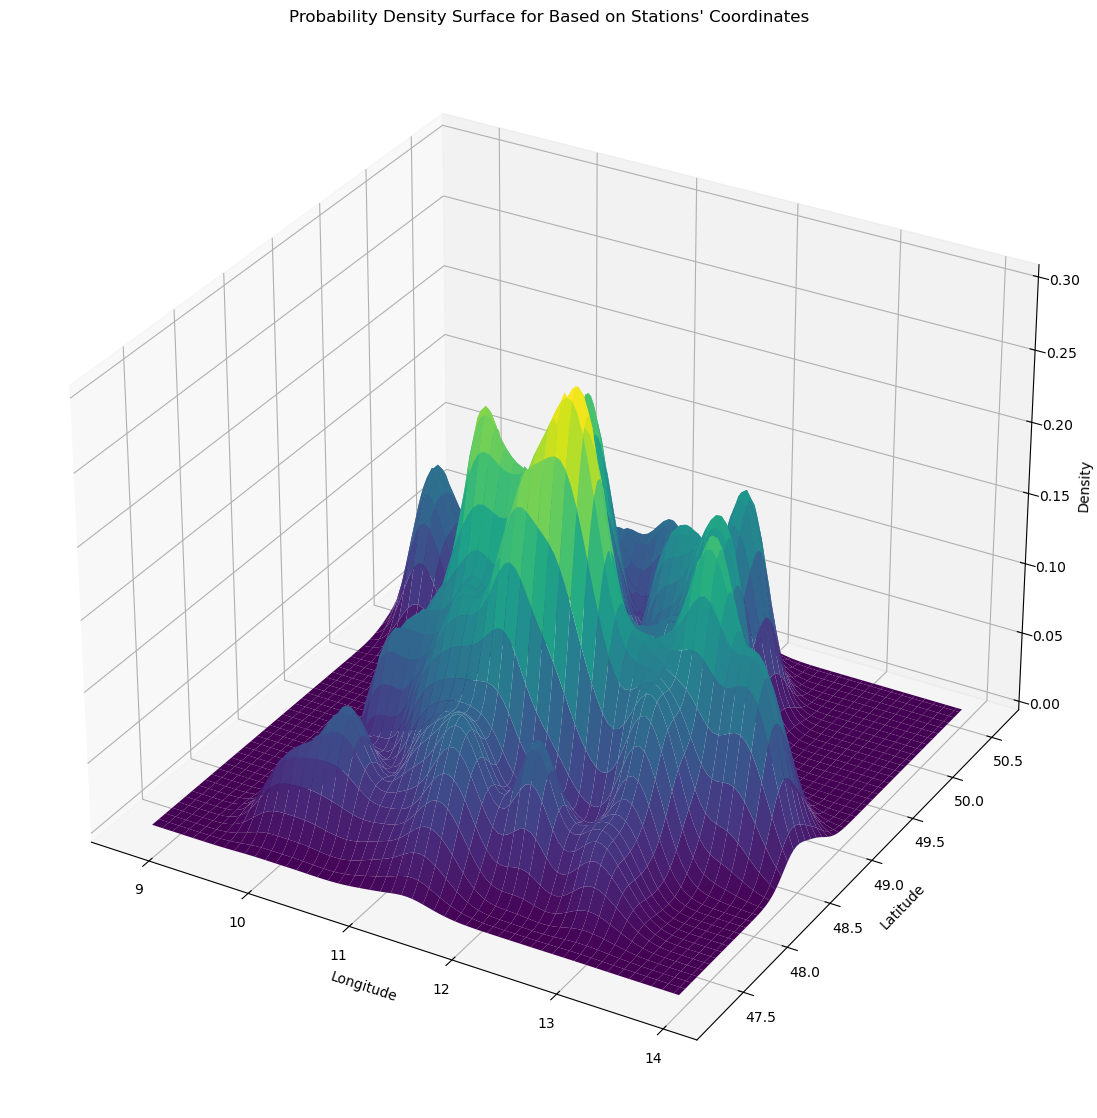

In [10]:
# plot the 3d density surface

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surf = ax.plot_surface(xx, yy, density_values, cmap='viridis', edgecolor='none')

#Add color bar which maps values to colors
#cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
#cbar.set_label('Density')

# Labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Density')
ax.set_title("Probability Density Surface for Based on Stations' Coordinates")

# Show plot
plt.show()

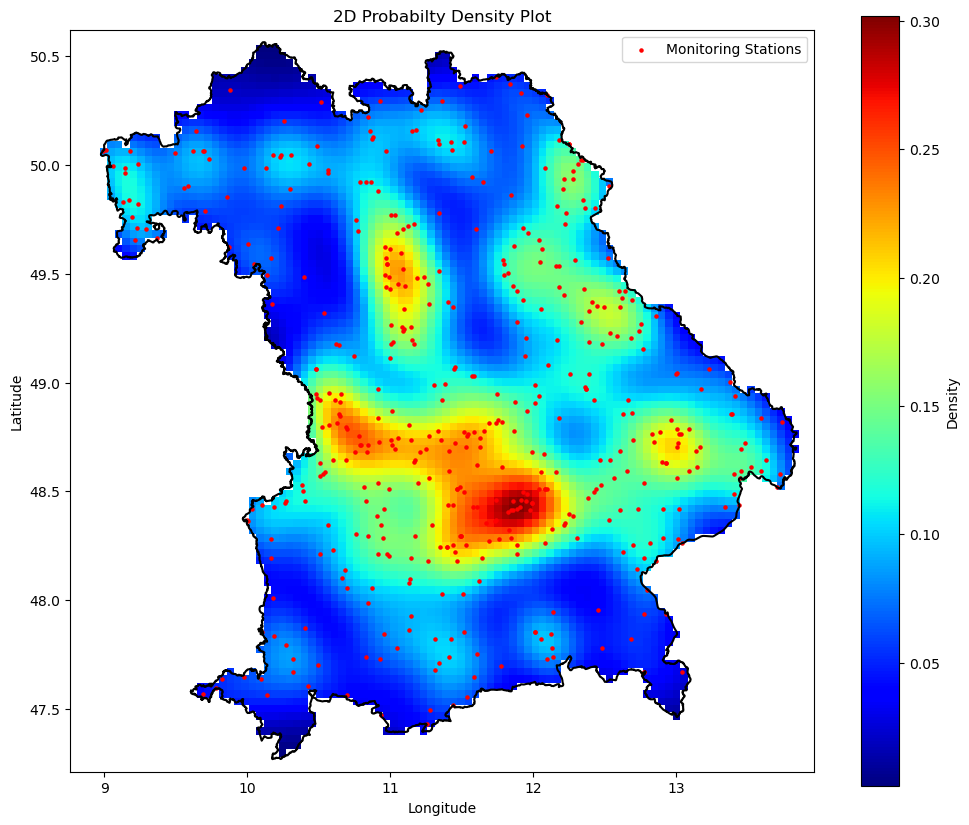

In [11]:
# Create a mask for the Bavaria polygon
bavaria_mask = np.zeros_like(xx, dtype=bool)
for poly in bavaria_polygon.geometry:
    for x_idx, x in enumerate(xx[:, 0]):
        for y_idx, y in enumerate(yy[0, :]):
            point = Point(x, y)
            if poly.contains(point):
                bavaria_mask[x_idx, y_idx] = True

# Apply mask
masked_density_values = np.ma.array(density_values, mask=~bavaria_mask)

# Plotting the density surface and the Bavaria map
fig, ax = plt.subplots(figsize=(12, 10))
cf = ax.pcolormesh(xx, yy, masked_density_values,  cmap='jet')
fig.colorbar(cf, ax=ax, label='Density')
bavaria_polygon.boundary.plot(ax=ax, color='black')
ax.scatter(final_df_jul_new['lon'], final_df_jul_new['lat'], c='red', s=5, label='Monitoring Stations')

# set plot properties
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('2D Probabilty Density Plot')
ax.legend()
plt.show()

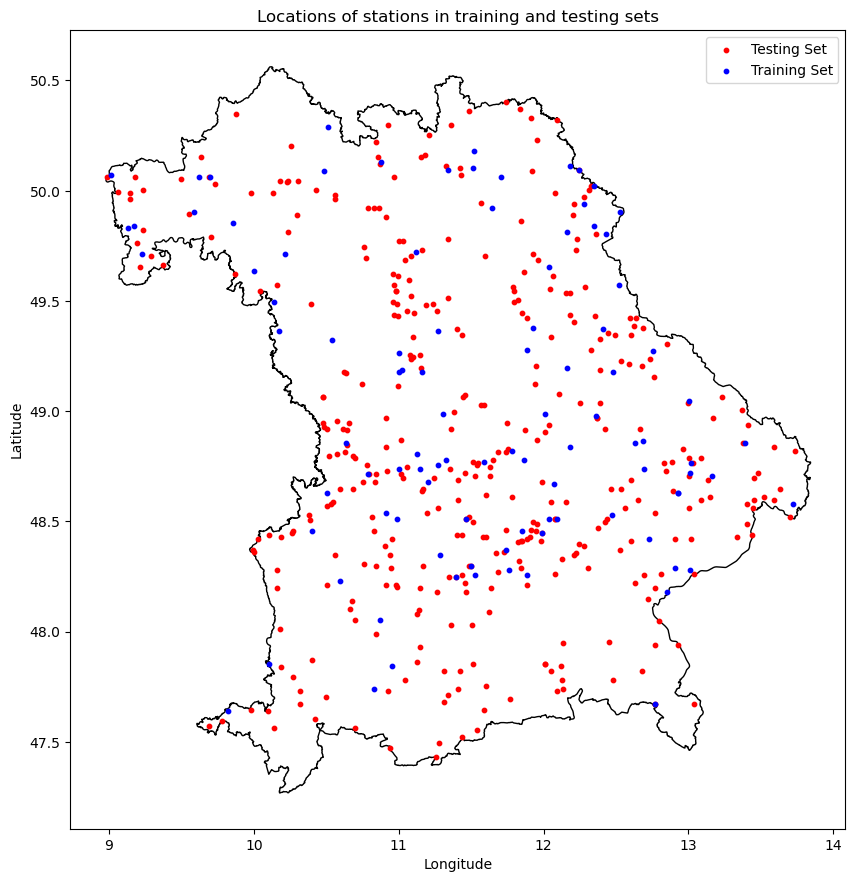

In [12]:
fig, ax = plt.subplots(figsize=(10,12))
bavaria_polygon.plot(ax = ax,color='white', edgecolor='black')
plt.scatter(sorted_df.loc[train_ind,'lon'], sorted_df.loc[train_ind,'lat'], color='red',s=10, label='Testing Set' )
plt.scatter(sorted_df.loc[test_ind,'lon'], sorted_df.loc[test_ind,'lat'], color='blue',s=10, label = 'Training Set' )
plt.title('Locations of stations in training and testing sets')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

## Default models
These are the default models without changing any parameters

In [13]:
# model :default, with spatial split, using box cox data


model_default_wss_bc = RandomForestRegressor(random_state = 42)
model_default_wss_bc.fit(X_train, y_train)
y_pred_default_wss_bc = model_default_wss_bc.predict(X_test)
rmse_model_default_wss_bc = np.sqrt(mean_squared_error(y_test, y_pred_default_wss_bc))
r2_model_default_wss_bc = r2_score(y_test, y_pred_default_wss_bc)
r_model_default_wss_bc = pearson_corr_coeff(y_test, y_pred_default_wss_bc)
print('RMSE, model = default wss bc: ',rmse_model_default_wss_bc)
print('R2, model = default wss bc: ', r2_model_default_wss_bc)
print('R, model = default wss bc: ', r_model_default_wss_bc)

RMSE, model = default wss bc:  0.8728643239173385
R2, model = default wss bc:  0.3204657920846581
R, model = default wss bc:  0.5780000534283849


In [14]:
# model: default, with spatial split, using original data


y_train_og = sorted_df.iloc[train_ind, 0]
y_test_og = sorted_df.iloc[test_ind, 0]

model_default_wss_og = RandomForestRegressor(random_state = 42)
model_default_wss_og.fit(X_train, y_train_og)
y_pred_default_wss_og = model_default_wss_og.predict(X_test)
rmse_model_default_wss_og = np.sqrt(mean_squared_error(y_test_og, y_pred_default_wss_og))
r2_model_default_wss_og = r2_score(y_test_og, y_pred_default_wss_og)
r_model_default_wss_og = pearson_corr_coeff(y_test_og, y_pred_default_wss_og)
print('RMSE, model = default wss og: ',rmse_model_default_wss_og)
print('R2, model = default wss og: ', r2_model_default_wss_og)
print('R, model = default wss og: ', r_model_default_wss_og)

RMSE, model = default wss og:  1.7468737197897852
R2, model = default wss og:  0.29298468416432955
R, model = default wss og:  0.5543784081506188


In [15]:
# model: default, NO spatial split, using box cox data

X_nss = scaler.transform(final_df_jul_new.iloc[:, 7:])
y_nss = final_df_jul_new.iloc[:,1]
X_train_nss, X_test_nss, y_train_nss, y_test_nss = train_test_split(X_nss, y_nss, test_size=0.2, random_state=42)

model_default_nss_bc = RandomForestRegressor(random_state = 42)
model_default_nss_bc.fit(X_train_nss, y_train_nss)
y_pred_default_nss_bc = model_default_nss_bc.predict(X_test_nss)
rmse_model_default_nss_bc = np.sqrt(mean_squared_error(y_test_nss, y_pred_default_nss_bc))
r2_model_default_nss_bc = r2_score(y_test_nss, y_pred_default_nss_bc)
r_model_default_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_default_nss_bc)
print('RMSE, model = default nss bc: ',rmse_model_default_nss_bc)
print('R2, model = default nss bc: ', r2_model_default_nss_bc)
print('R, model = default nss bc: ', r_model_default_nss_bc)

RMSE, model = default nss bc:  0.8030287790601319
R2, model = default nss bc:  0.45987548573192394
R, model = default nss bc:  0.6800749006557142


## Hyperparameter Tuning

In [16]:
# Optimization of model: with spatial split, using box cox transformed data

def objective_opt_wss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    score = cross_val_score(model_tuning, X_train, y_train, cv=5, scoring = "r2", n_jobs=1)
    mean_score = score.mean()  
    return mean_score
    
    

In [17]:
study_opt_wss_bc =  optuna.create_study(direction = "maximize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-06-05 22:32:27,836] A new study created in memory with name: no-name-4f4889ef-c7b9-41c1-9965-f5233552e14d


In [18]:
study_opt_wss_bc.optimize(objective_opt_wss_bc, n_trials = 1000, n_jobs=1)

[I 2024-06-05 22:32:34,024] Trial 0 finished with value: 0.4439137171374433 and parameters: {'n_estimators': 225, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.4439137171374433.
[I 2024-06-05 22:32:36,398] Trial 1 finished with value: 0.42843284590842 and parameters: {'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.4439137171374433.
[I 2024-06-05 22:32:43,958] Trial 2 finished with value: 0.42438784432404 and parameters: {'n_estimators': 361, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.4439137171374433.
[I 2024-06-05 22:33:07,438] Trial 3 finished with value: 0.46265858621403566 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.46265858621403566.
[I 2024-06-05 22:33:13,655] Trial 4 finished with value: 0.45923617638305797 and parameters:

In [19]:
study_opt_wss_bc.best_params

{'n_estimators': 96,
 'max_depth': 9,
 'min_samples_split': 4,
 'min_samples_leaf': 5}

In [20]:
study_opt_wss_bc_best_params = study_opt_wss_bc.best_params

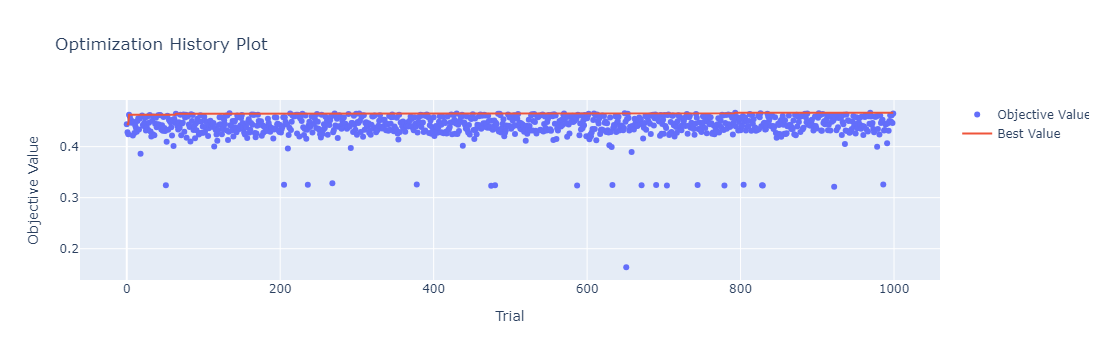

In [21]:
optuna.visualization.plot_optimization_history(study_opt_wss_bc)

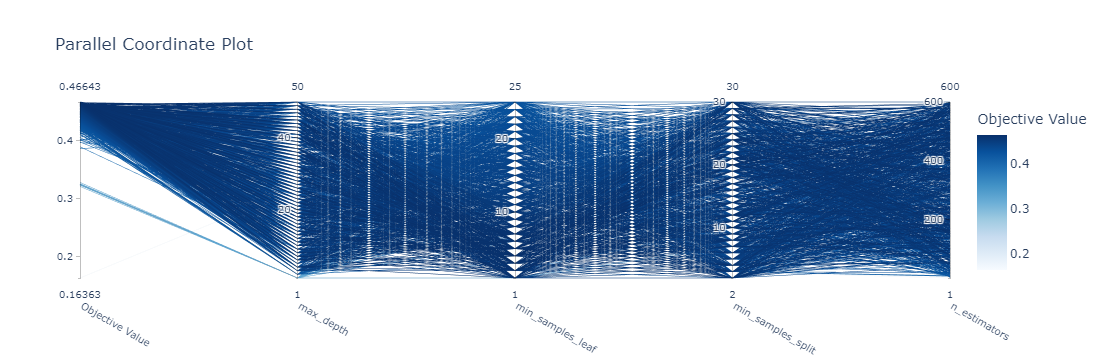

In [22]:
optuna.visualization.plot_parallel_coordinate(study_opt_wss_bc)

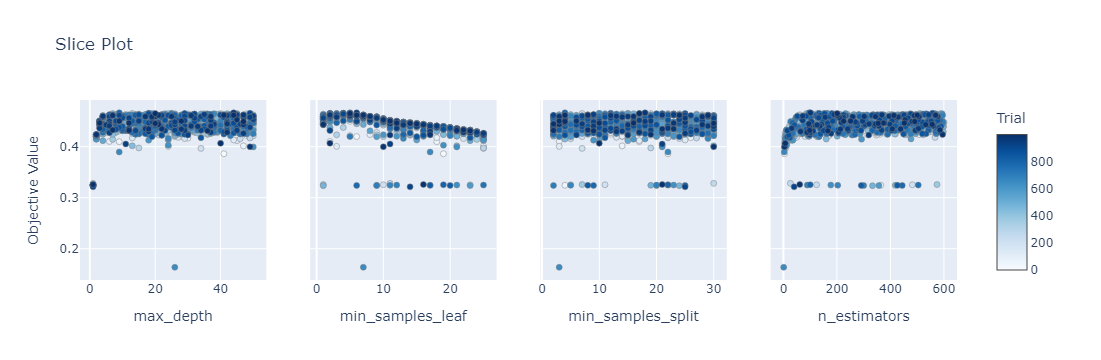

In [23]:
optuna.visualization.plot_slice(study_opt_wss_bc, params = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf' ])

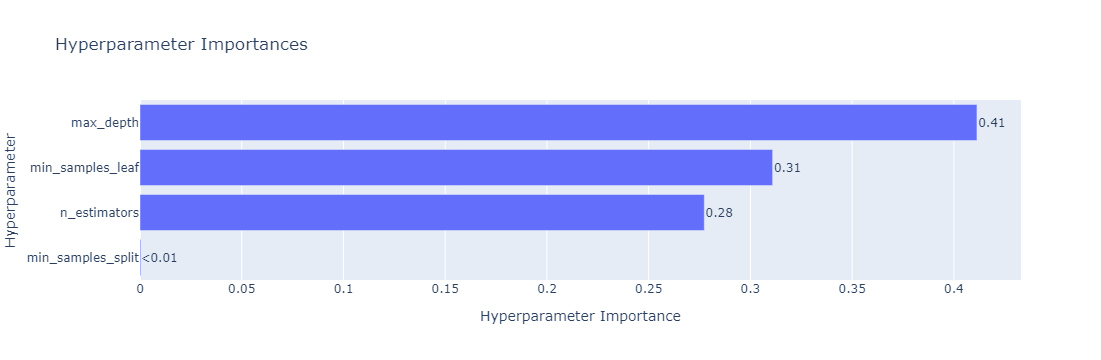

In [24]:
optuna.visualization.plot_param_importances(study_opt_wss_bc)

In [25]:
# Optimization of model: with spatial split, using original data

def objective_opt_wss_og(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    score = cross_val_score(model_tuning, X_train, y_train_og, cv=5, scoring = "r2", n_jobs=1)
    mean_score = score.mean()  
    return mean_score
    
    

In [26]:
study_opt_wss_og =  optuna.create_study(direction = "maximize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-06-06 00:55:40,450] A new study created in memory with name: no-name-cd2dd3d6-e3fb-4f7b-b325-e82dbe3fe87b


In [27]:
study_opt_wss_og.optimize(objective_opt_wss_og, n_trials = 1000, n_jobs=1)

[I 2024-06-06 00:55:46,088] Trial 0 finished with value: 0.38475300907080767 and parameters: {'n_estimators': 225, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.38475300907080767.
[I 2024-06-06 00:55:48,070] Trial 1 finished with value: 0.3744827799391538 and parameters: {'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.38475300907080767.
[I 2024-06-06 00:55:54,990] Trial 2 finished with value: 0.37656893254558405 and parameters: {'n_estimators': 361, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.38475300907080767.
[I 2024-06-06 00:56:16,393] Trial 3 finished with value: 0.39840341041519495 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.39840341041519495.
[I 2024-06-06 00:56:22,532] Trial 4 finished with value: 0.39708378845095543 and pa

In [28]:
study_opt_wss_og.best_params

{'n_estimators': 567,
 'max_depth': 24,
 'min_samples_split': 19,
 'min_samples_leaf': 5}

In [29]:
study_opt_wss_og_best_params = study_opt_wss_og.best_params

In [30]:
# Optimization of model: NO spatial split, using box cox data

def objective_opt_nss_bc(trial):
    n_estimators = trial.suggest_int("n_estimators", 1, 600)
    max_depth = trial.suggest_int("max_depth", 1, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 25)

    model_tuning = RandomForestRegressor(n_estimators =n_estimators, max_depth =max_depth, 
                                         min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, random_state = 42)
    score = cross_val_score(model_tuning, X_train_nss, y_train_nss, cv=5, scoring = "r2", n_jobs=1)
    mean_score = score.mean()  
    return mean_score

In [31]:
study_opt_nss_bc =  optuna.create_study(direction = "maximize", sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-06-06 03:18:47,297] A new study created in memory with name: no-name-a033bd52-7bde-46c3-ac7e-39a0845090c3


In [32]:
study_opt_nss_bc.optimize(objective_opt_nss_bc, n_trials = 1000, n_jobs=1)

[I 2024-06-06 03:18:52,895] Trial 0 finished with value: 0.4612668844202645 and parameters: {'n_estimators': 225, 'max_depth': 48, 'min_samples_split': 23, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.4612668844202645.
[I 2024-06-06 03:18:54,848] Trial 1 finished with value: 0.44549629906333843 and parameters: {'n_estimators': 94, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 22}. Best is trial 0 with value: 0.4612668844202645.
[I 2024-06-06 03:19:01,815] Trial 2 finished with value: 0.44093798920823424 and parameters: {'n_estimators': 361, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 25}. Best is trial 0 with value: 0.4612668844202645.
[I 2024-06-06 03:19:22,731] Trial 3 finished with value: 0.47056502857067173 and parameters: {'n_estimators': 500, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.47056502857067173.
[I 2024-06-06 03:19:28,792] Trial 4 finished with value: 0.47212377152666607 and param

In [33]:
study_opt_nss_bc.best_params

{'n_estimators': 557,
 'max_depth': 49,
 'min_samples_split': 18,
 'min_samples_leaf': 4}

In [34]:
study_opt_nss_bc_best_params = study_opt_nss_bc.best_params

## Fitting and testing model with best parameters


In [35]:
# with spatial split, box cox data

best_n_estimators_opt_wss_bc = study_opt_wss_bc_best_params['n_estimators']
best_max_depth_opt_wss_bc = study_opt_wss_bc_best_params['max_depth']
best_min_samples_split_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_wss_bc = study_opt_wss_bc_best_params['min_samples_leaf']

best_model_opt_wss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_wss_bc, max_depth = best_max_depth_opt_wss_bc , 
                                              min_samples_split= best_min_samples_split_opt_wss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_wss_bc, random_state=42)

best_model_opt_wss_bc.fit(X_train, y_train)

y_pred_opt_wss_bc = best_model_opt_wss_bc.predict(X_test)

rmse_model_opt_wss_bc = np.sqrt(mean_squared_error(y_test, y_pred_opt_wss_bc))
r2_model_opt_wss_bc = r2_score(y_test, y_pred_opt_wss_bc)
r_model_opt_wss_bc = pearson_corr_coeff(y_test, y_pred_opt_wss_bc)

In [36]:
# with spatial split, original data

best_n_estimators_opt_wss_og = study_opt_wss_og_best_params['n_estimators']
best_max_depth_opt_wss_og = study_opt_wss_og_best_params['max_depth']
best_min_samples_split_opt_wss_og = study_opt_wss_og_best_params['min_samples_split']
best_min_samples_leaf_opt_wss_og = study_opt_wss_og_best_params['min_samples_leaf']

best_model_opt_wss_og = RandomForestRegressor(n_estimators = best_n_estimators_opt_wss_og, max_depth = best_max_depth_opt_wss_og , 
                                              min_samples_split= best_min_samples_split_opt_wss_og, 
                                              min_samples_leaf=best_min_samples_leaf_opt_wss_og, random_state=42)

best_model_opt_wss_og.fit(X_train, y_train_og)

y_pred_opt_wss_og = best_model_opt_wss_og.predict(X_test)

rmse_model_opt_wss_og = np.sqrt(mean_squared_error(y_test_og, y_pred_opt_wss_og))
r2_model_opt_wss_og = r2_score(y_test_og, y_pred_opt_wss_og)
r_model_opt_wss_og = pearson_corr_coeff(y_test_og, y_pred_opt_wss_og)

In [37]:
# NO spatial split, box cox data

best_n_estimators_opt_nss_bc = study_opt_nss_bc_best_params['n_estimators']
best_max_depth_opt_nss_bc = study_opt_nss_bc_best_params['max_depth']
best_min_samples_split_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_split']
best_min_samples_leaf_opt_nss_bc = study_opt_nss_bc_best_params['min_samples_leaf']

best_model_opt_nss_bc = RandomForestRegressor(n_estimators = best_n_estimators_opt_nss_bc, max_depth = best_max_depth_opt_nss_bc , 
                                              min_samples_split= best_min_samples_split_opt_nss_bc, 
                                              min_samples_leaf=best_min_samples_leaf_opt_nss_bc, random_state=42)

best_model_opt_nss_bc.fit(X_train_nss, y_train_nss)

y_pred_opt_nss_bc = best_model_opt_nss_bc.predict(X_test_nss)

rmse_model_opt_nss_bc = np.sqrt(mean_squared_error(y_test_nss, y_pred_opt_nss_bc))
r2_model_opt_nss_bc = r2_score(y_test_nss, y_pred_opt_nss_bc)
r_model_opt_nss_bc = pearson_corr_coeff(y_test_nss, y_pred_opt_nss_bc)

In [38]:
r2_model_opt_nss_bc

0.49221249093656516

In [39]:
best_min_samples_split_opt_nss_bc

18

## Plot figures

In [40]:
print(rmse_model_opt_nss_bc, r2_model_opt_nss_bc, r_model_opt_nss_bc)

0.7786193137943019 0.49221249093656516 0.7017038741388089


Text(0.5, 1.08, 'Correlation Plot for Default Model (using Spatial Split)')

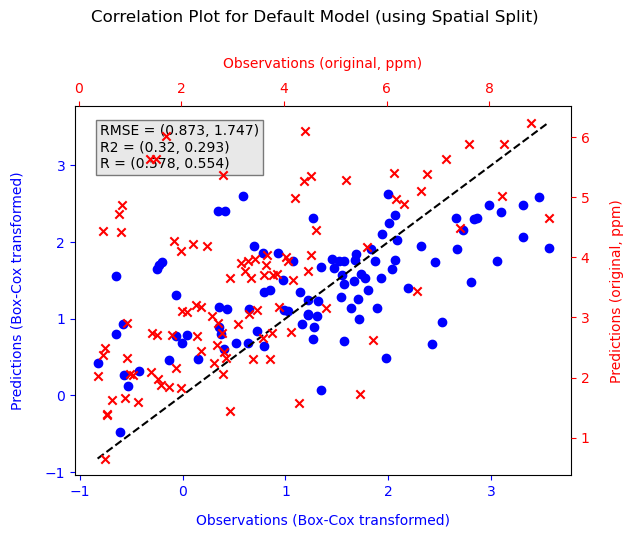

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_default_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed)', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed)', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_default_wss_bc,3), np.round(rmse_model_default_wss_og,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_default_wss_bc, 3), np.round(r2_model_default_wss_og,3)),
    r'R = ({}, {})'.format(np.round(r_model_default_wss_bc, 3), np.round(r_model_default_wss_og, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test)
max_ax1 = max(y_test)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_og, y_pred_default_wss_og, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (original, ppm)', color = 'red')
ax2.set_ylabel('Predictions (original, ppm)', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Default Model (using Spatial Split)', y = 1.08)

Text(0.5, 1.08, 'Correlation Plot for Optimzed Model (using Spatial Split)')

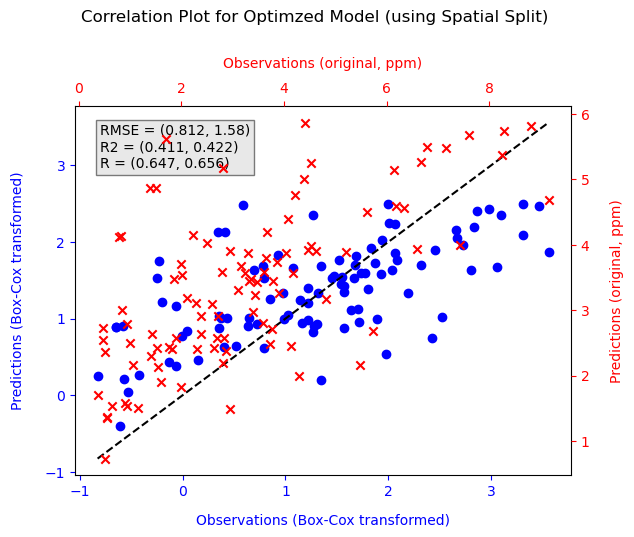

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_opt_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed)', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed)', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_opt_wss_bc,3), np.round(rmse_model_opt_wss_og,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_opt_wss_bc, 3), np.round(r2_model_opt_wss_og,3)),
    r'R = ({}, {})'.format(np.round(r_model_opt_wss_bc, 3), np.round(r_model_opt_wss_og, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test)
max_ax1 = max(y_test)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_og, y_pred_opt_wss_og, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (original, ppm)', color = 'red')
ax2.set_ylabel('Predictions (original, ppm)', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Optimzed Model (using Spatial Split)', y = 1.08)

Text(0.5, 1.08, 'Correlation Plot for Default and Optimized Models (Without Spatial Split)')

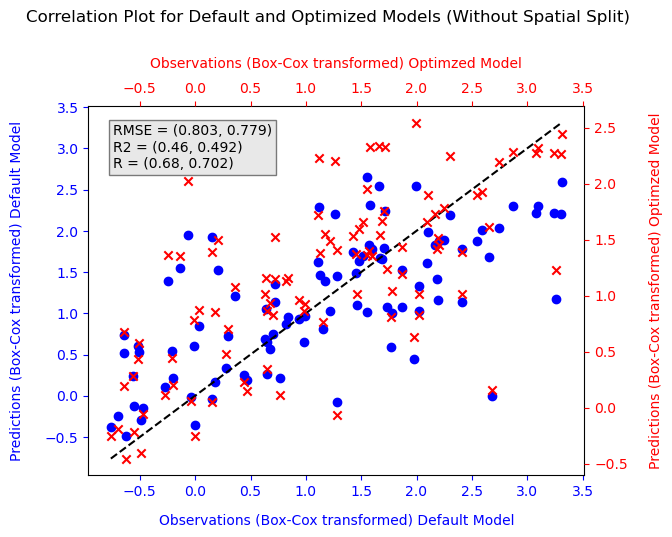

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test_nss, y_pred_default_nss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed) Default Model', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed) Default Model', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_default_nss_bc,3), np.round(rmse_model_opt_nss_bc,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_default_nss_bc, 3), np.round(r2_model_opt_nss_bc,3)),
    r'R = ({}, {})'.format(np.round(r_model_default_nss_bc, 3), np.round(r_model_opt_nss_bc, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test_nss)
max_ax1 = max(y_test_nss)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_nss, y_pred_opt_nss_bc, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (Box-Cox transformed) Optimzed Model', color = 'red')
ax2.set_ylabel('Predictions (Box-Cox transformed) Optimzed Model', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Default and Optimized Models (Without Spatial Split)', y = 1.08)

Text(0.5, 1.08, 'Correlation Plot for Default Models (With and Without Spatial Split)')

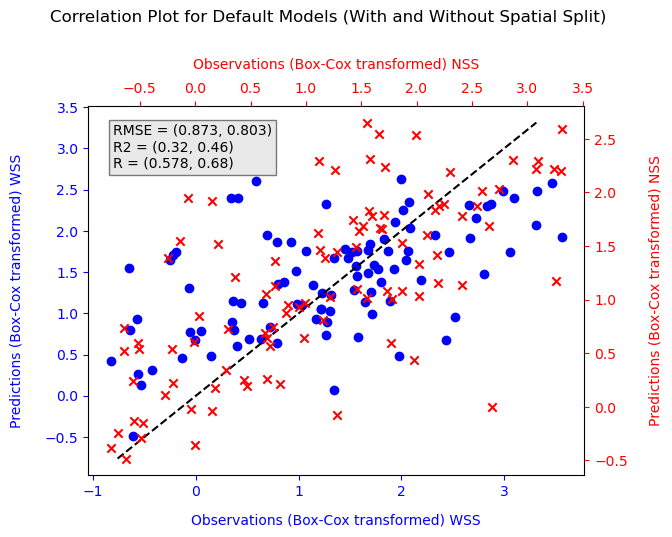

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_default_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed) WSS', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed) WSS', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_default_wss_bc,3), np.round(rmse_model_default_nss_bc,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_default_wss_bc, 3), np.round(r2_model_default_nss_bc,3)),
    r'R = ({}, {})'.format(np.round(r_model_default_wss_bc, 3), np.round(r_model_default_nss_bc, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test_nss)
max_ax1 = max(y_test_nss)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_nss, y_pred_default_nss_bc, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (Box-Cox transformed) NSS', color = 'red')
ax2.set_ylabel('Predictions (Box-Cox transformed) NSS', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Default Models (With and Without Spatial Split)', y = 1.08)

Text(0.5, 1.08, 'Correlation Plot for Optimzed Models (With and Without Spatial Split)')

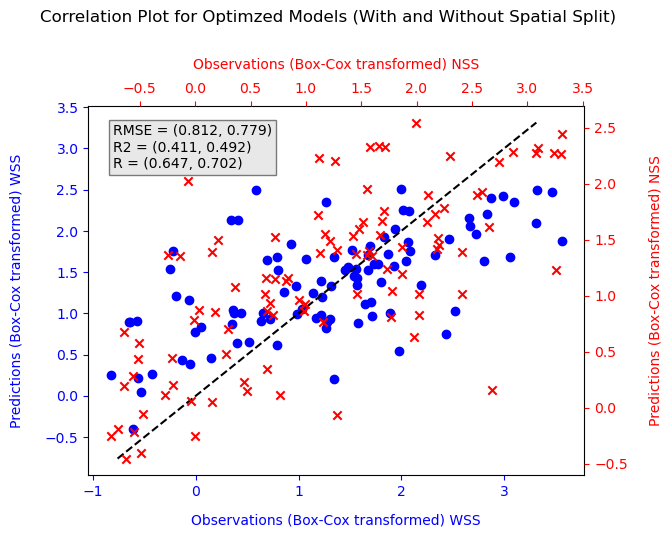

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(111, label = '1')
ax2 = fig.add_subplot(111, label = '2', frame_on = False)

ax1.scatter(y_test, y_pred_opt_wss_bc, marker = 'o', color ='blue')
ax1.set_xlabel('Observations (Box-Cox transformed) WSS', color = 'blue')
ax1.set_ylabel('Predictions (Box-Cox transformed) WSS', color = 'blue')
ax1.tick_params(axis = 'x', color = 'blue', labelcolor = 'blue')
ax1.tick_params(axis = 'y', color = 'blue', labelcolor = 'blue')
ax1.yaxis.labelpad = 15
ax1.xaxis.labelpad = 10

props = dict(boxstyle='square', facecolor='lightgrey', alpha=0.5)

textstr = '\n'.join((
    r'RMSE = ({}, {})'.format(np.round(rmse_model_opt_wss_bc,3), np.round(rmse_model_opt_nss_bc,3)),
    r'R2 = ({}, {})'.format(np.round(r2_model_opt_wss_bc, 3), np.round(r2_model_opt_nss_bc,3)),
    r'R = ({}, {})'.format(np.round(r_model_opt_wss_bc, 3), np.round(r_model_opt_nss_bc, 3))))

ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

min_ax1 = min(y_test_nss)
max_ax1 = max(y_test_nss)
ax1.plot([min_ax1, max_ax1], [min_ax1, max_ax1], linestyle = 'dashed', color = 'black')


ax2.scatter(y_test_nss, y_pred_opt_nss_bc, marker = 'x', color ='red')
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.set_xlabel('Observations (Box-Cox transformed) NSS', color = 'red')
ax2.set_ylabel('Predictions (Box-Cox transformed) NSS', color = 'red')
ax2.xaxis.set_label_position('top')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis = 'x', color = 'red', labelcolor = 'red')
ax2.tick_params(axis = 'y', color = 'red', labelcolor = 'red')
ax2.yaxis.labelpad = 15
ax2.xaxis.labelpad = 10

fig.suptitle('Correlation Plot for Optimzed Models (With and Without Spatial Split)', y = 1.08)

In [46]:
np.round(r2_model_default_wss_og, 3)

0.293

## Feature Importance

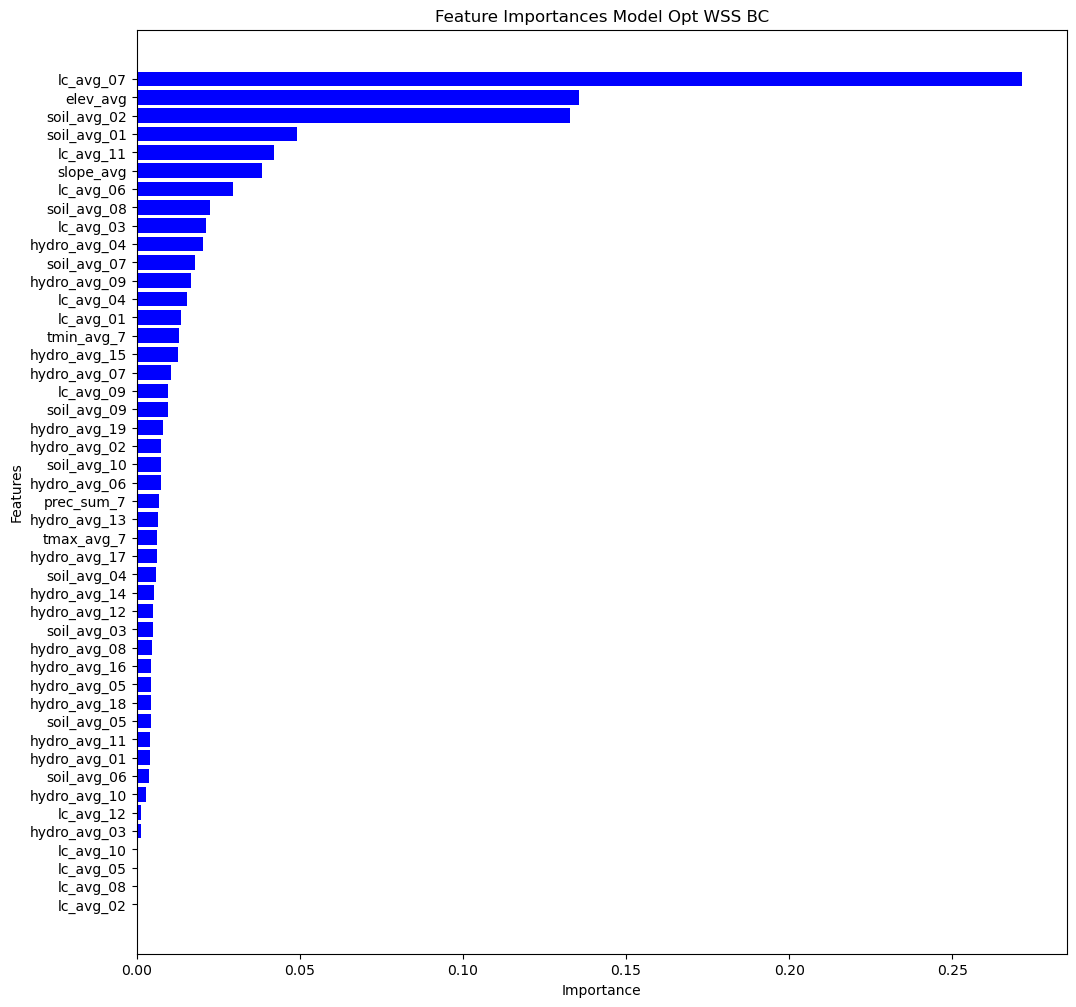

In [47]:
feature_importances_opt_wss_bc = best_model_opt_wss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_wss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt WSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_wss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_jul_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

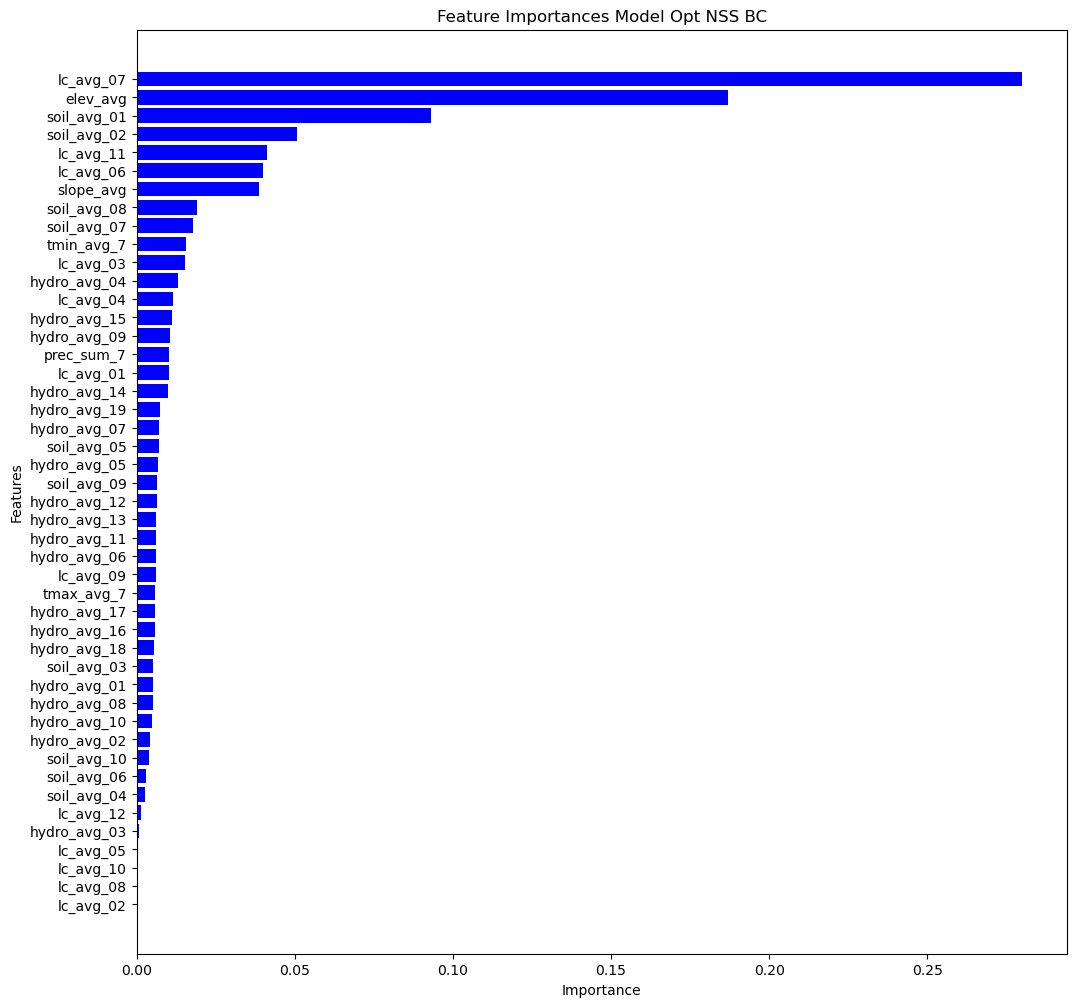

In [48]:
feature_importances_opt_nss_bc = best_model_opt_nss_bc.feature_importances_

indices = np.argsort(feature_importances_opt_nss_bc)

# Prepare the figure
plt.figure(figsize=(12, 12))
plt.title('Feature Importances Model Opt NSS BC')

# Create horizontal bars
plt.barh(range(len(indices)), feature_importances_opt_nss_bc[indices], color='b', align='center')

# Add feature names as y-tick labels
plt.yticks(range(len(indices)), [final_df_jul_new.columns[7:][i] for i in indices])

# Label the axes
plt.xlabel('Importance')
plt.ylabel('Features')

# Show the plot
plt.show()

In [49]:
np.sum(np.sort(feature_importances_opt_wss_bc*100))

100.0

In [50]:
np.sort(feature_importances_opt_nss_bc*100)

array([0.00000000e+00, 0.00000000e+00, 4.26037878e-04, 3.39668062e-03,
       6.05124142e-02, 1.50868000e-01, 2.70757736e-01, 3.10756245e-01,
       3.94117786e-01, 4.27235581e-01, 4.77110761e-01, 5.01943507e-01,
       5.18444565e-01, 5.20431448e-01, 5.63468195e-01, 5.74106998e-01,
       5.80812641e-01, 5.95291690e-01, 5.96877368e-01, 6.08068926e-01,
       6.12198820e-01, 6.14570134e-01, 6.50769583e-01, 6.56663318e-01,
       6.69550526e-01, 6.95047876e-01, 7.11953243e-01, 7.29387377e-01,
       9.85567104e-01, 1.01366841e+00, 1.02326162e+00, 1.06223173e+00,
       1.12970926e+00, 1.13444267e+00, 1.29592337e+00, 1.51388824e+00,
       1.56271365e+00, 1.78631467e+00, 1.92299244e+00, 3.86764827e+00,
       4.00131997e+00, 4.13408905e+00, 5.06054756e+00, 9.31538686e+00,
       1.86936911e+01, 2.80018366e+01])

In [51]:
# Save required information to disk
month = '_jul'

variables2save = [X_train, X_test, y_train, y_test,
                  rmse_model_default_wss_bc, r2_model_default_wss_bc, r_model_default_wss_bc,
                  y_pred_default_wss_bc,
                  study_opt_wss_bc,
                  study_opt_wss_bc_best_params, 
                  y_pred_opt_wss_bc,
                 y_train_og, y_test_og,
                 rmse_model_default_wss_og, r2_model_default_wss_og, r_model_default_wss_og,
                 y_pred_default_wss_og,
                  study_opt_wss_og,
                  study_opt_wss_og_best_params, 
                  y_pred_opt_wss_og,
                 X_train_nss, X_test_nss, y_train_nss, y_test_nss,
                 rmse_model_default_nss_bc, r2_model_default_nss_bc, r_model_default_nss_bc,
                  y_pred_default_nss_bc,
                  study_opt_nss_bc,
                  study_opt_nss_bc_best_params, 
                  y_pred_opt_nss_bc,
                 model_default_wss_bc,
                 model_default_wss_og,
                 model_default_nss_bc,
                 best_model_opt_wss_bc,
                 best_model_opt_wss_og,
                 best_model_opt_nss_bc]

variables_name = ['X_train', 'X_test', 'y_train', 'y_test',
                  'rmse_model_default_wss_bc', 'r2_model_default_wss_bc', 'r_model_default_wss_bc',
                  'y_pred_default_wss_bc',
                  'study_opt_wss_bc',
                  'study_opt_wss_bc_best_params', 
                  'y_pred_opt_wss_bc',
                 'y_train_og', 'y_test_og',
                 'rmse_model_default_wss_og', 'r2_model_default_wss_og', 'r_model_default_wss_og',
                 'y_pred_default_wss_og',
                  'study_opt_wss_og',
                  'study_opt_wss_og_best_params', 
                  'y_pred_opt_wss_og',
                 'X_train_nss', 'X_test_nss', 'y_train_nss', 'y_test_nss',
                 'rmse_model_default_nss_bc', 'r2_model_default_nss_bc', 'r_model_default_nss_bc',
                  'y_pred_default_nss_bc',
                  'study_opt_nss_bc',
                  'study_opt_nss_bc_best_params', 
                  'y_pred_opt_nss_bc',
                 'model_default_wss_bc',
                 'model_default_wss_og',
                 'model_default_nss_bc',
                 'best_model_opt_wss_bc',
                 'best_model_opt_wss_og',
                 'best_model_opt_nss_bc']

variables_save_name = [i+month for i in variables_name]

for i in range(len(variables2save)):
    # save the variables
    filepath = variables_save_name[i]
    with open(filepath, 'wb') as file:
        pickle.dump(variables2save[i], file)